# Main Functions

In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances


def get_Y_dists(Y):
    """Takes in an n*n matrix Y, returns a matrix of (1+||y_i-y_j||^2)^-1."""
    return np.power(1 + pairwise_distances(Y, metric="sqeuclidean"), -1)


def get_Q(Y_dists):
    """Normalize a similarity matrix, exlucding self-similarity."""
    np.fill_diagonal(Y_dists, 0)
    return Y_dists/np.sum(Y_dists)


def get_grad(P, Q, Y, Y_dists):
    """Compute the t-SNE gradient.
    
    Inputs:
    P - n*n high-dimensional affinity matrix.
    Q - n*n low-dimensional affinity matrix.
    Y_dists - n*n matrix of similarities between the low-dimensional
              factors.
    Y - n*d matrix of the current d-dimensional embedding.
    
    Outputs:
    dY - n*d matrix where each row is the gradient of the t-SNE cost."""
    
    R = P - Q
    dY = np.zeros_like(Y)

    for i in range(Y.shape[0]):
        dY[i,:] = 4*np.dot(R[i,:]*Y_dists[i,:], Y[i,:] - Y)
            
    return dY


def pca(X, k):
    """Use PCA to project X to k dimensions."""
    
    X = (X - np.mean(X, axis=0))/np.std(X, axis=0)
    _, U = np.linalg.eig(X.T@X)
    
    return X@U[:,:k]

# Examples
### Testing the gradient
First test the code using data we've worked through by hand. Here `Q` is not generated by `get_Q`.

In [2]:
P = np.array([[1,2,3],
             [4,5,6],
             [7,8,9]])

Q = np.array([[9,7,8],
             [3,1,2],
             [6,5,4]])

Y = np.array([[-0.5, 0.25],
             [-1, 2],
             [3, -6]])

P = P + P.T
Q = Q + Q.T
Y_dists = get_Y_dists(Y)

print(P)
print(Q)
print(np.round(Y_dists,3))

[[ 2  6 10]
 [ 6 10 14]
 [10 14 18]]
[[18 10 14]
 [10  2  7]
 [14  7  8]]
[[1.    0.232 0.019]
 [0.232 1.    0.012]
 [0.019 0.012 1.   ]]


In [3]:
dY = get_grad(P, Q, Y, Y_dists)
print(dY)

[[-0.78458262  4.58116461]
 [ 0.47235641 -3.72732152]
 [ 0.3122262  -0.85384309]]


Now test the code using `get_Q`.

In [4]:
Q = get_Q(Y_dists)
print(Q)

[[0.         0.44026563 0.0362943 ]
 [0.44026563 0.         0.02344007]
 [0.0362943  0.02344007 0.        ]]


In [5]:
dY = get_grad(P, Q, Y, Y_dists)
print(dY)

[[ -0.08808391  -4.26286879]
 [ -5.33922949  14.54610029]
 [  5.4273134  -10.2832315 ]]


### Testing PCA
Test our custom implementation of PCA on the iris dataset.

In [6]:
import pandas as pd

url = 'https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv'
iris = pd.read_csv(url)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


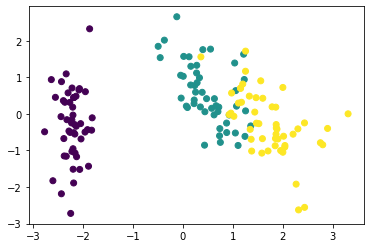

In [8]:
from matplotlib import pyplot as plt

X = np.array(iris[["sepal_length", "sepal_width", "petal_length", "petal_width"]])
labels = iris.species.astype("category").cat.codes

X_pca = pca(X, 2)

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)
plt.show()